Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Micro-Ultrasound Prostate Segmentation with MONAI

This tutorial demonstrates how to perform 2D/3D prostate segmentation using MONAI on the Micro-Ultrasound Prostate Segmentation Dataset.

The tutorial covers:
1. Custom dataset class for handling Micro-Ultrasound data with multiple annotation types
2. Data transforms for training and validation
3. UNet model setup for segmentation
4. Training loop with validation
5. Visualization of results
6. Model evaluation

The Micro-Ultrasound Prostate Segmentation Dataset can be downloaded from [Zenodo](https://zenodo.org/record/10475293).

**Target:** Prostate  
**Modality:** Micro-Ultrasound  
**Task:** Segmentation


In [1]:
%env BUILD_MONAI=1
!pip install -q "monai[all] @ git+https://github.com/Project-MONAI/MONAI.git"

env: BUILD_MONAI=1


In [1]:
!python -c "import monai" || pip install -q "monai[itk, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt

from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd,ScaleIntensityd, RandCropByPosNegLabeld, RandRotate90d, RandFlipd, Resized, Activations, AsDiscrete
from monai.data import DataLoader, decollate_batch
from torch.utils.data import Subset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from monai.inferers import sliding_window_inference

import torch

In [3]:
ROOT_DIR = "./dataset"
os.makedirs(ROOT_DIR, exist_ok=True)
print(f"Dataset will be stored in: {os.path.abspath(ROOT_DIR)}")

Dataset will be stored in: /teamspace/studios/this_studio/dataset


## Define Custom Dataset Class

The `MicroUSProstateDataset` class handles:
- Automatic dataset download and extraction
- Mapping between image files and annotation files based on annotation type
- Support for multiple annotation types (expert, non_expert, master, medical, clinician)


In [4]:
import os
import sys
from pathlib import Path
from typing import Callable, Sequence

from monai.data import CacheDataset
from monai.transforms import LoadImaged
from monai.apps.utils import download_and_extract


ANNOTATION_MAP = {
    "expert": "expert_annotations",
    "non_expert": "non_expert_annotations",
    "master": "master_student_annotations",
    "medical": "medical_student_annotations",
    "clinician": "clinician_annotations",
}

FILE_PREFIX_MAP = {
    "expert": "expert_annotation",
    "non_expert": "non_expert_annotation",
    "master": "master_student_annotation",
    "medical": "medical_student_annotation",
    "clinician": "clinician_annotation",
}


class MicroUSProstateDataset(CacheDataset):
    
    ANNOTATION_MAP = {
    "expert": "expert_annotations",
    "non_expert": "non_expert_annotations",
    "master": "master_student_annotations",
    "medical": "medical_student_annotations",
    "clinician": "clinician_annotations",
}

    FILE_PREFIX_MAP = {
    "expert": "expert_annotation",
    "non_expert": "non_expert_annotation",
    "master": "master_student_annotation",
    "medical": "medical_student_annotation",
    "clinician": "clinician_annotation",
}

    resource = "https://zenodo.org/record/10475293/files/Micro_Ultrasound_Prostate_Segmentation_Dataset.zip"
    md5 = "263379f4ba5a9e4d8496c763b801f82e"
    compressed_file_name = "Micro_Ultrasound_Prostate_Segmentation_Dataset.zip"
    dataset_folder_name = "Micro_Ultrasound_Prostate_Segmentation_Dataset"

    def __init__(
        self,
        root_dir: str,
        section: str,
        annotation_type: str = "expert",
        transform: Sequence[Callable] | Callable = LoadImaged(keys=["image", "label"]),
        download: bool = False,
        seed: int = 0,
        cache_rate: float = 0.0,   
        cache_num: int = sys.maxsize,
        num_workers: int = 1,
        progress: bool = True,
    ):
        root_dir = Path(root_dir)

        if not root_dir.is_dir():
            raise ValueError(f"Root directory must be a directory: {root_dir}")

        if annotation_type not in ANNOTATION_MAP:
            raise ValueError(f"Unsupported annotation_type: {annotation_type}")

        if section not in ["training", "test"]:
            raise ValueError("section must be 'training' or 'test'")

        # Download if needed
        self.dataset_folder = root_dir / self.dataset_folder_name
        if download:
            zip_path = root_dir / self.compressed_file_name
            download_and_extract(
                url=self.resource,
                filepath=zip_path,
                output_dir=root_dir,
                hash_val=self.md5,
                hash_type="md5",
                progress=progress,
            )

        if not self.dataset_folder.is_dir():
            raise RuntimeError(f"Dataset folder missing: {self.dataset_folder}")

        self.section = "train" if section == "training" else "test"
        self.annotation_folder_name = ANNOTATION_MAP[annotation_type]
        self.file_prefix = FILE_PREFIX_MAP[annotation_type]

        data = self._generate_data_list()

        super().__init__(
            data=data,
            transform=transform,
            cache_rate=cache_rate,
            cache_num=cache_num,
            num_workers=num_workers,
            progress=progress,
        )

    def _generate_data_list(self):
        section_dir = self.dataset_folder / self.section
        image_dir = section_dir / "micro_ultrasound_scans"
        label_dir = section_dir / self.annotation_folder_name


        if not image_dir.is_dir() or not label_dir.is_dir():
            raise RuntimeError("Missing required folders.")

        # Correct file filtering: .nii.gz → suffix is ".gz"
        image_files = sorted(f for f in image_dir.iterdir() if f.name.endswith(".nii.gz"))

        print(f"Found {len(image_files)} image files.")

        data_list = []
        label_prefix = self.file_prefix

        for img in image_files:
            # Remove "microUS_" → get train_01.nii.gz
            suffix = img.name.replace("microUS_", "")
            label_name = f"{label_prefix}_{suffix}"
            label_path = label_dir / label_name

            if not label_path.exists():
                print(f"Warning: label missing for {img.name}, expected {label_name}")
                continue

            data_list.append({
                "image": str(img),
                "label": str(label_path),
            })

        if not data_list:
            raise RuntimeError("No subjects found. Check dataset structure.")

        print(f"Final paired subjects: {len(data_list)}")
        return data_list


## Setup transforms for training and validation

Here we define transforms for:
- **Training**: Includes data augmentation (random crops, rotations, flips) to improve model generalization
- **Validation**: Only includes necessary preprocessing (load, ensure channel first, spacing, intensity scaling)


In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Resized(keys=["image", "label"], spatial_size=(256, 256, 48)),
        ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Resized(keys=["image", "label"], spatial_size=(256, 256, 48)),
        ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
    ]
)


## Create training and validation datasets

We'll use the training section for both training and validation (split internally), and the test section for final evaluation.


In [14]:
# Create full training dataset
full_train_ds = MicroUSProstateDataset(
    root_dir=ROOT_DIR,
    section="training",
    annotation_type="expert",  # Using expert annotations
    transform=train_transforms,
    download=False,  # Set to True to download the dataset automatically
    cache_rate=0.0,
    num_workers=0,
)

# Split into training and validation (80/20 split)
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(full_train_ds)))

# Create validation dataset 
val_ds = MicroUSProstateDataset(
    root_dir=ROOT_DIR,
    section="training",
    annotation_type="expert",
    transform=val_transforms,
    download=False,
    cache_rate = 0.0,
    num_workers=0,
)

# Use subset of indices for validation
from torch.utils.data import Subset
train_ds = Subset(full_train_ds, train_indices)
val_ds_subset = Subset(val_ds, val_indices)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds_subset)}")

Found 55 image files.
Final paired subjects: 55
Found 55 image files.
Final paired subjects: 55
Training samples: 44
Validation samples: 11


## Check data shape and visualize a sample


Image shape: torch.Size([1, 1, 256, 256, 48]), Label shape: torch.Size([1, 1, 256, 256, 48])
Detected 3D data


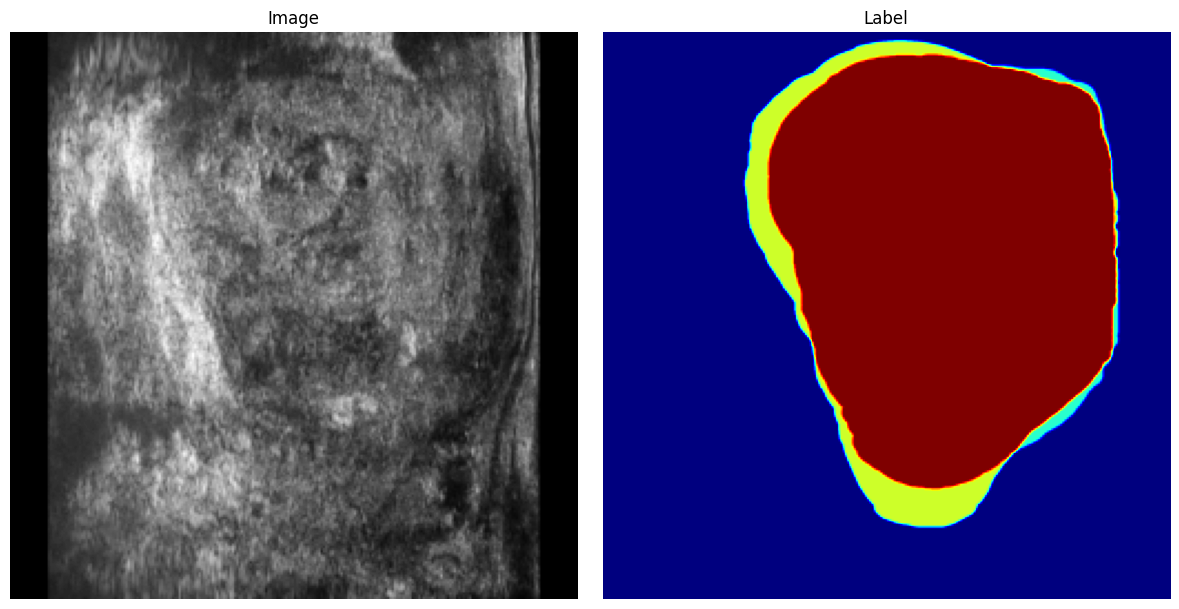

In [15]:
from monai.config import print_config
from monai.utils import set_determinism, first

# Check a sample from training data to determine data shape
check_loader = DataLoader(train_ds, batch_size=1, num_workers=0)
check_data = first(check_loader)
image, label = check_data["image"], check_data["label"]
print(f"Image shape: {image.shape}, Label shape: {label.shape}")

# Store spatial dimensions for later use
spatial_dims = 3 if len(image.shape) == 5 else 2
print(f"Detected {spatial_dims}D data")

# Visualize a sample slice
if len(image.shape) == 5:  # [B, C, H, W, D]
    slice_idx = image.shape[-1] // 2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image[0, 0, :, :, slice_idx].cpu().numpy(), cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(label[0, 0, :, :, slice_idx].cpu().numpy(), cmap="jet")
    axes[1].set_title("Label")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
elif len(image.shape) == 4:  # [B, C, H, W]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image[0, 0].cpu().numpy(), cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(label[0, 0].cpu().numpy(), cmap="jet")
    axes[1].set_title("Label")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()


## Create Model, Loss, and Optimizer

We'll use a 3D UNet model for segmentation with Dice Loss and Adam optimizer.


In [8]:
spatial_dims = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Using {spatial_dims}D UNet")

# Create UNet model
model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,
    out_channels=2,  # Background + foreground
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    norm=("batch", {"eps": 1e-5, "momentum": 0.1}),
).to(device)

# Loss function
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Metric
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Post-processing transforms
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cuda
Using 3D UNet
Model parameters: 1,187,921


## Training loop

Execute the training process with validation at regular intervals.


In [9]:
max_epochs = 5 # Using a smaller number of epochs for the sake of the tutorial
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Create data loaders for training
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(val_ds_subset, batch_size=1, num_workers=0)

print("Starting training...")
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        if step % 10 == 0:
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                # Use sliding window inference for larger images
                roi_size = (96, 96, 96) if spatial_dims == 3 else (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(ROOT_DIR, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"Current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nBest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

print(f"Training completed! Best metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


Starting training...
----------
Epoch 1/5


10/22, train_loss: 0.4650
20/22, train_loss: 0.4314
Epoch 1 average loss: 0.4685
----------
Epoch 2/5
10/22, train_loss: 0.4155
20/22, train_loss: 0.3867
Epoch 2 average loss: 0.4037
----------
Epoch 3/5
10/22, train_loss: 0.3391
20/22, train_loss: 0.3157
Epoch 3 average loss: 0.3470
----------
Epoch 4/5
10/22, train_loss: 0.2827
20/22, train_loss: 0.2844
Epoch 4 average loss: 0.3084
----------
Epoch 5/5
10/22, train_loss: 0.2760
20/22, train_loss: 0.2915
Epoch 5 average loss: 0.2697


Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


saved new best metric model
Current epoch: 5 current mean dice: 0.6499
Best mean dice: 0.6499 at epoch: 5
Training completed! Best metric: 0.6499 at epoch: 5


## Plot training loss and validation metric


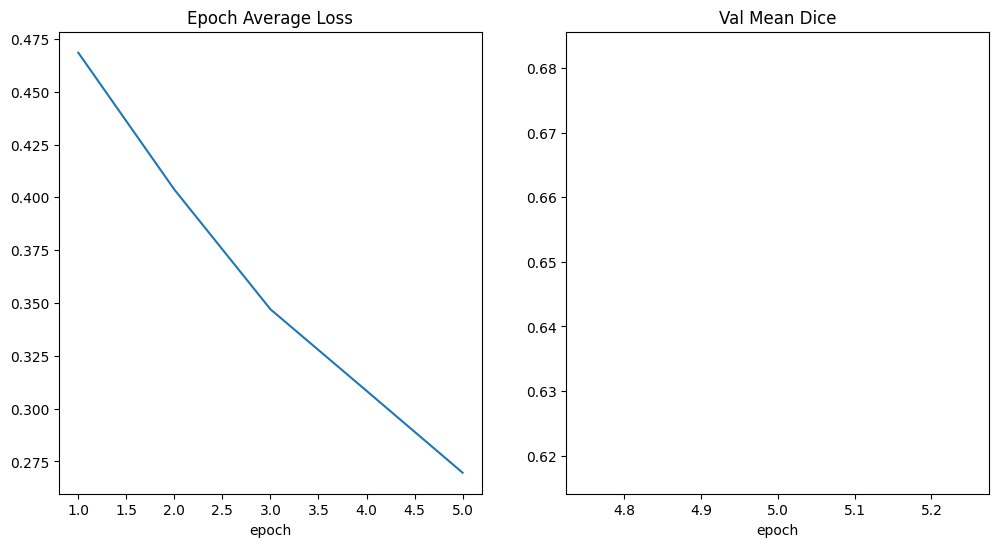

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


## Visualize best model predictions

Load the best model and visualize predictions on validation samples.


Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


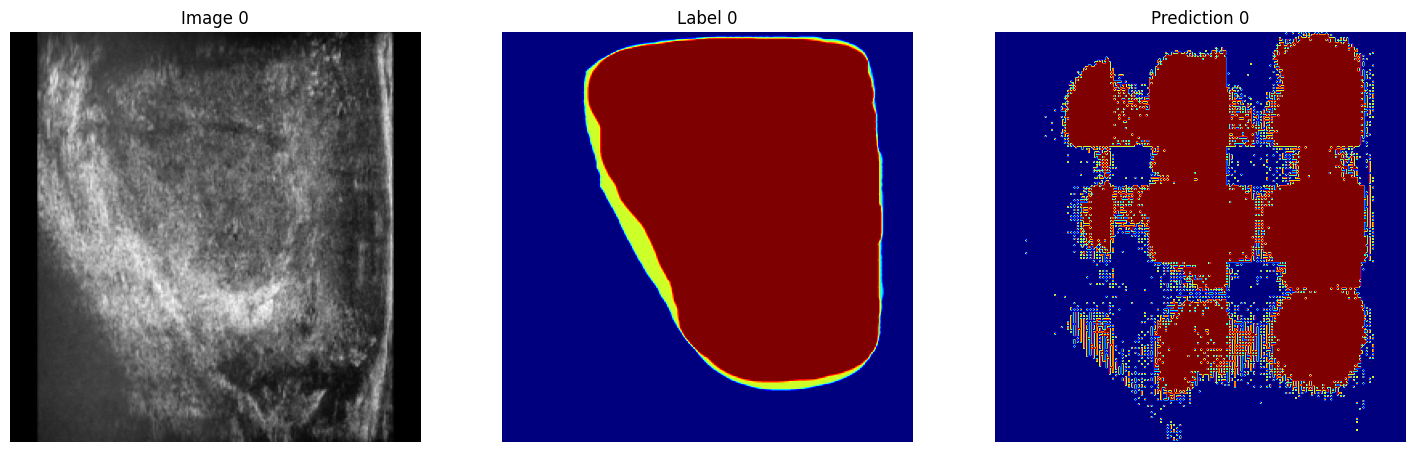

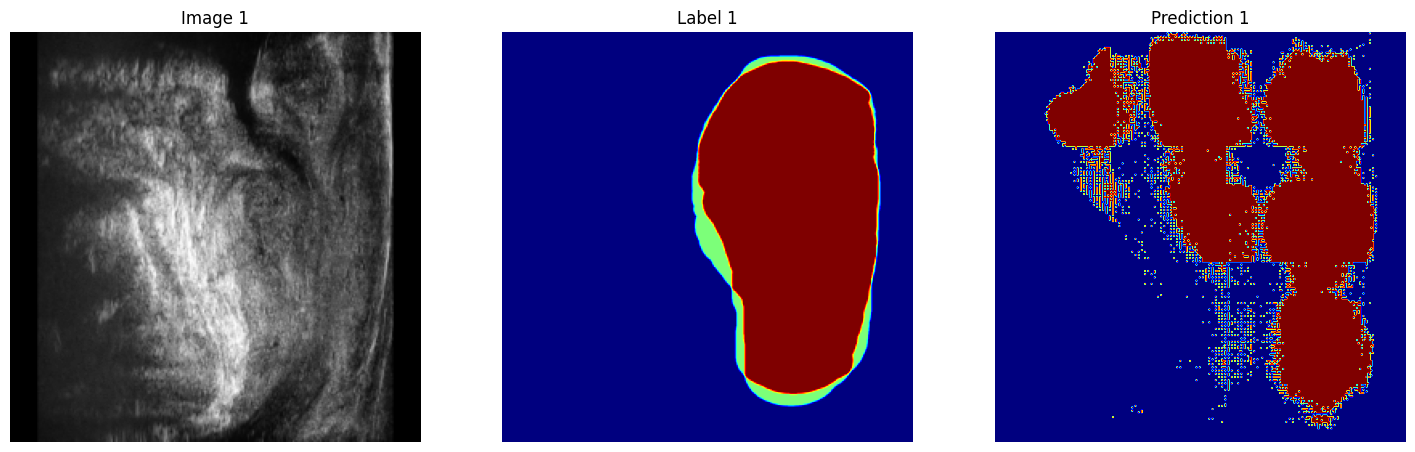

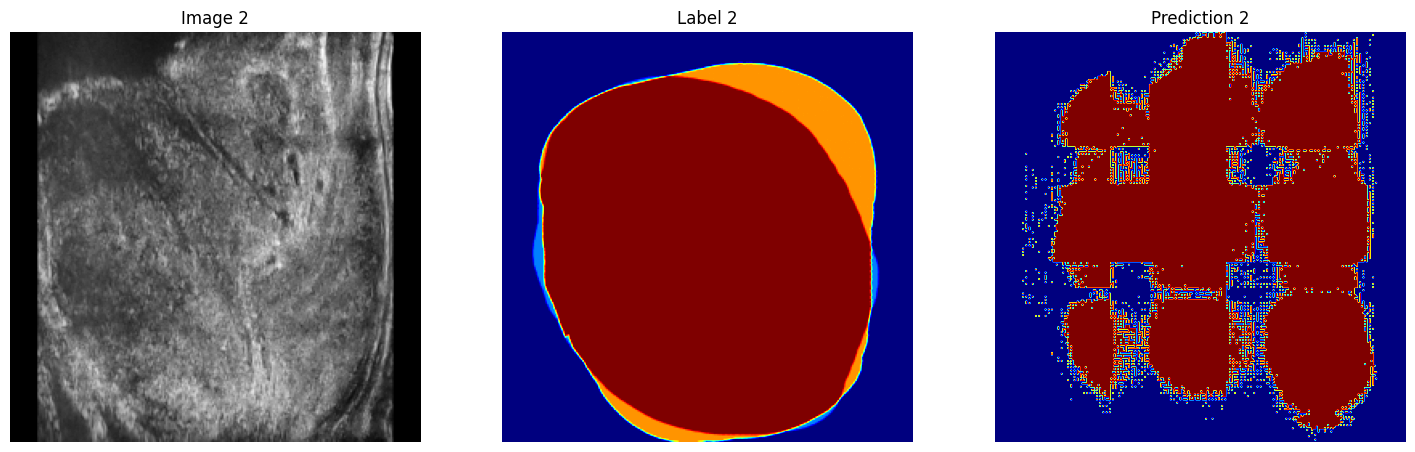

In [17]:
model.load_state_dict(torch.load(os.path.join(ROOT_DIR, "best_metric_model.pth"), weights_only=True))
model.eval()
val_loader = DataLoader(val_ds_subset, batch_size=1, num_workers=0)
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_inputs = val_data["image"].to(device)
        roi_size = (96, 96, 96) if spatial_dims == 3 else (96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

        # Get the slice for visualization
        if spatial_dims == 3:
            slice_idx = val_inputs.shape[-1] // 2
            img_slice = val_inputs[0, 0, :, :, slice_idx].cpu()
            label_slice = val_data["label"][0, 0, :, :, slice_idx].cpu()
            pred_slice = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx]
        else:
            img_slice = val_inputs[0, 0].cpu()
            label_slice = val_data["label"][0, 0].cpu()
            pred_slice = torch.argmax(val_outputs, dim=1).detach().cpu()[0]

        # Plot
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Image {i}")
        plt.imshow(img_slice, cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title(f"Label {i}")
        plt.imshow(label_slice, cmap="jet")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title(f"Prediction {i}")
        plt.imshow(pred_slice, cmap="jet")
        plt.axis("off")
        plt.show()

        if i == 2:  # Show first 3 samples
            break


## Evaluation on test set

Evaluate the model on the test set to get final performance metrics.


In [18]:
# Create test dataset
test_ds = MicroUSProstateDataset(
    root_dir=ROOT_DIR,
    section="test",
    annotation_type="expert",
    transform=val_transforms,
    download=False,
    cache_rate=1.0,
    num_workers=0,
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

# Evaluate on test set
model.eval()
test_dice_metric = DiceMetric(include_background=False, reduction="mean")
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data["image"].to(device), test_data["label"].to(device)
        roi_size = (96, 96, 96) if spatial_dims == 3 else (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        test_dice_metric(y_pred=test_outputs, y=test_labels)

test_metric = test_dice_metric.aggregate().item()
test_dice_metric.reset()

print(f"Test set mean Dice score: {test_metric:.4f}")


Found 20 image files.
Final paired subjects: 20


Loading dataset: 100%|██████████| 20/20 [04:50<00:00, 14.52s/it]


Test set mean Dice score: 0.6243
